# Evaluation of fMRIPrep: assessing robustness and quality of results

This notebook is a supplemental material to the paper: [doi here]

### 0. Setting up

In [1]:
%matplotlib inline
import os
import json
import pandas as pd
import glob
import numpy as np
from pathlib import Path
import matplotlib as mpl
mpl.use('pgf')

import matplotlib.pyplot as plt

OUTPUT_PATH = Path(os.getenv('FMRIPREP_FIGURES', os.getcwd()))

/home/oesteban/.anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/oesteban/.anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/oesteban/.anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/oesteban/.anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/oesteban/.anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/oesteban/.anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", li

## Evolution of quality from 1.0.0 to 1.0.7

### Read data in

In [2]:
df = pd.read_csv('fmriprep_qc.tsv', sep='\t')
df.describe()

,overall,t1_reconall,t1_seg_brainmask,t1_t1_2_mni,bold_rois,bold_bbr,bold_syn_sdc
count,109.000000,109.000000,109.000000,109.000000,106.000000,106.000000,103.000000
mean,2.528287,2.727064,2.611621,2.821101,2.653057,2.834710,2.558120
std,0.500028,0.464655,0.516350,0.448882,0.359703,0.242025,0.319758
min,0.500000,0.000000,0.000000,0.000000,1.812500,2.000000,1.875000
25%,2.500000,2.500000,2.500000,3.000000,2.462500,2.750000,2.333333
50%,2.500000,3.000000,2.750000,3.000000,2.750000,2.943750,2.500000
75%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.833333
max,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000


## Plotting overall quality rating evolution

{0.5: 2, 1.5: 5, 2.0: 9, 2.5: 26, 3.0: 12, nan: 1}
{1.25: 1, 1.75: 2, 2.25: 3, 2.333333333333333: 1, 2.5: 10, 2.75: 19, 3.0: 19}


/home/oesteban/.anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Text(1.3,-0.25,'\\noindent\\parbox{10.0cm}{\\raggedright \\textit{DS000108 and DS000148 \\textbf{improved the most} after addressing particular issues}}')

<Figure size 432x288 with 0 Axes>

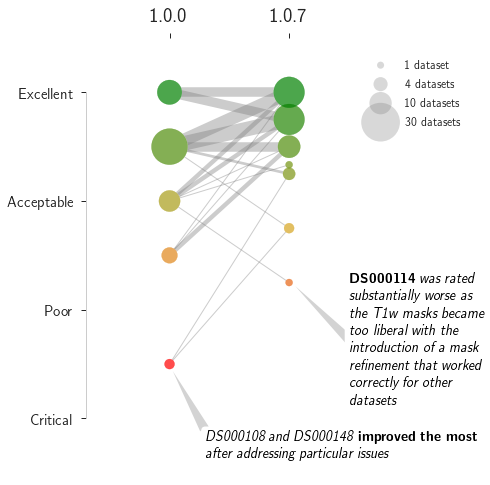

In [3]:
from collections import Counter
from matplotlib.colors import LinearSegmentedColormap, Normalize
import seaborn as sns
from scipy import stats

plt.clf()

sns.set_style("whitegrid", {
    'ytick.major.size': 5,
    'xtick.major.size': 5,
})
sns.set_context("notebook", font_scale=1)

pgf_with_custom_preamble = {
#     'font.sans-serif': ['Helvetica Light'],
#     'font.family': 'sans-serif', # use serif/main font for text elements
    'text.usetex': True,    # use inline math for ticks
    'pgf.rcfonts': False,   # don't setup fonts from rc parameters
    'pgf.texsystem': 'xelatex',
    'verbose.level': 'debug-annoying',
    "pgf.preamble": [
#         r'\renewcommand{\sfdefault}{phv}',
#         r'\usepackage[scaled=.92]{helvet}',
        r'\usepackage{fontspec}',
        r"""\usepackage{fontspec}
\setsansfont{HelveticaLTStd-Light}[
Extension=.otf,
BoldFont=HelveticaLTStd-Bold,
ItalicFont=HelveticaLTStd-LightObl,
BoldItalicFont=HelveticaLTStd-BoldObl,
]
\setmainfont{HelveticaLTStd-Light}[
Extension=.otf,
BoldFont=HelveticaLTStd-Bold,
ItalicFont=HelveticaLTStd-LightObl,
BoldItalicFont=HelveticaLTStd-BoldObl,
]
""",
        r'\renewcommand\familydefault{\sfdefault}',
#         r'\setsansfont[Extension=.otf]{Helvetica-LightOblique}',
#         r'\setmainfont[Extension=.ttf]{DejaVuSansCondensed}',
#         r'\setmainfont[Extension=.otf]{FiraSans-Light}',
#         r'\setsansfont[Extension=.otf]{FiraSans-Light}',
    ]
}
mpl.rcParams.update(pgf_with_custom_preamble)

norm = Normalize(vmin=0.5, vmax=3.0)

# Show each observation with a scatterplot
# sns.stripplot(x='qc', y="overall", data=two, jitter=True)
cm = LinearSegmentedColormap.from_list('ratings', ['red', 'goldenrod', 'green'], N=50)

lines = [tuple(df[df['dataset'].str.contains(ds)].sort_values(by=['version', 'overall'])[['overall']].values.ravel())
         for ds in set(df[['dataset']].values.ravel().tolist())]
lines = [l for l in lines if not np.any(np.isnan(l))]
#         plt.plot((1, 2), y, color='gray', linewidth=1.0, alpha=0.6)

factor = 50

fig = plt.figure(figsize=(3, 8))
ax = plt.gca()
for u, c in Counter(lines).items():
     ax.plot((1, 2), u, color='gray', linewidth=(c-1) * 1.7 + 1, zorder=1, alpha=0.4)

# Plot qc1
df0 = df[df.version.str.contains('1.0.0')]
unique, counts = np.unique(df0[['overall']].values.ravel(), return_counts=True)
qc1_counts = dict(zip(unique, counts))
ax.scatter([1] * len(unique), unique, c='w', s=counts * factor, zorder=2)
qc1_scatter = ax.scatter([1] * len(unique), unique, c=cm(norm(unique)), alpha=0.7, s=counts * factor, zorder=3)

print(dict(zip(unique, counts)))

# Plot qc2
df1 = df[df.version.str.contains('1.0.7')]
unique, counts = np.unique(df1[['overall']].values.ravel(), return_counts=True)
qc2_counts = dict(zip(unique, counts))
ax.scatter([2] * len(unique), unique, c='w', s=counts * factor, zorder=2)
qc2_scatter = ax.scatter([2] * len(unique), unique, c=cm(norm(unique)), alpha=0.7, s=counts * factor, zorder=3)

print(dict(zip(unique, counts)))

ax.set(yticks=[0.0, 1.0, 2.0, 3.0])
ax.set(yticklabels=['Critical', 'Poor', 'Acceptable', 'Excellent'])
ax.set_xlim((0.8, 2.2))
ax.set_ylim((-0.5, 3.5))


sc = [
    plt.scatter([],[], s=factor * 1, color='gray', edgecolors='none', alpha=.3),
    plt.scatter([],[], s=factor * 4, color='gray', edgecolors='none', alpha=.3),
    plt.scatter([],[], s=factor * 10, color='gray', edgecolors='none', alpha=.3),
    plt.scatter([],[], s=factor * 30, color='gray', edgecolors='none', alpha=.3)
]

labels = ["1 dataset", "4 datasets", "10 datasets", "30 datasets"]

leg = plt.legend(sc, labels, ncol=1, frameon=False, fontsize=12,
                 handlelength=2, loc=1, borderpad = 1.2,
                 handletextpad=1, scatterpoints = 1,
                 bbox_to_anchor=(2.0, 1.0))

sns.despine(offset=60, trim=True);
sns.despine(bottom=True)


ax.set(xticks=[1, 2])
ax.set(xticklabels=['1.0.0', '1.0.7'])
ax.xaxis.tick_top()
ax.grid()
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)

annot1 = """\
Although \\textbf{the majority of datasets improved}, \
only three lowered their ratings"""

annot2 = """\
\\textbf{DS000114} was rated substantially worse as the T1w masks became \
too liberal with the introduction of a mask refinement that worked \
correctly for other datasets"""

annot3 = """\
DS000108 and DS000148 \\textbf{improved the most} after addressing particular \
issues"""

annotfmt = r"\noindent\parbox{{{0:.1f}cm}}{{\raggedright \textit{{{1}}}}}".format
# ax.annotate(
#     annotfmt(5.0, annot1),
#     xy=(2.05, 2), xycoords='data', xytext=(2.5, 1.9),
#     textcoords='data', va='center', color='k', size=14,
#     bbox=dict(boxstyle='round', fc='w', ec='k', color='none', lw=0),
#     arrowprops=dict(
#         arrowstyle='wedge,tail_width=0.7', lw=0, patchA=None, patchB=None,
#         fc='lightgray', ec='none', relpos=(0.02, 0.5)))

ax.annotate(
    annotfmt(5.0, annot2),
    xy=(2.04, 1.23), xycoords='data', xytext=(2.5, 0.7),
    textcoords='data', va='center', color='k', size=14,
    bbox=dict(boxstyle='round', fc='w', ec='k', color='none', lw=0),
    arrowprops=dict(
        arrowstyle='wedge,tail_width=0.7', lw=0, patchA=None, patchB=None,
        fc='lightgray', ec='none', relpos=(0.02, 0.5)))

ax.annotate(
    annotfmt(10.0, annot3),
    xy=(1.02, 0.45), xycoords='data', xytext=(1.3, -0.25),
    textcoords='data', va='center', color='k', size=14,
    bbox=dict(boxstyle='round', fc='w', ec='k', color='none', lw=0),
    arrowprops=dict(
        arrowstyle='wedge,tail_width=0.7', lw=0, patchA=None, patchB=None,
        fc='lightgray', ec='none', relpos=(0., 1.)))

# plt.savefig(str(OUTPUT_PATH / 'figure04.pdf'),
#             format='pdf', bbox_inches='tight', pad_inches=0.2, dpi=300)

## Plotting individual evolution per dataset, at all QC points

In [4]:
from scipy import stats
from seaborn.categorical import _CategoricalScatterPlotter
from seaborn.axisgrid import PairGrid
from matplotlib.colors import LinearSegmentedColormap, Normalize

class MyPairGrid(PairGrid):
    def __init__(self, data, data0, hue=None, hue_order=None, palette=None,
                 hue_kws=None, vars=None, x_vars=None, y_vars=None,
                 diag_sharey=True, size=2.5, aspect=1,
                 despine=True, dropna=True):
        super(MyPairGrid, self).__init__(
            data, hue=hue, hue_order=hue_order, palette=palette, hue_kws=hue_kws,
            vars=vars, x_vars=x_vars, y_vars=y_vars, diag_sharey=diag_sharey,
            size=size, aspect=aspect, despine=despine, dropna=dropna
        )
        data.index = data.dataset
        data0.index = data0.dataset
        self.data0 = data0.reindex(data.index)
        self.hue_names = None
        
    def map(self, func, **kwargs):
        """Plot with the same function in every subplot.
        Parameters
        ----------
        func : callable plotting function
            Must take x, y arrays as positional arguments and draw onto the
            "currently active" matplotlib Axes.
        """
        kw_color = kwargs.pop("color", None)

        for j, x_var in enumerate(self.x_vars):
            ax = self.axes[0, j]
            plt.sca(ax)
            func(self.data[[x_var]], self.data0[[x_var]], self.data[['dataset']],
                 **kwargs)

            self._clean_axis(ax)
            self._update_legend_data(ax)
            
            
def stripplot(x=None, y=None, hue=None, data=None, order=None, hue_order=None,
              jitter=False, dodge=False, orient=None, color=None, palette=None,
              size=5, edgecolor="gray", linewidth=0, ax=None, **kwargs):
    plotter = _StripPlotter(x, y, hue, data, order, hue_order,
                            jitter, dodge, orient, color, palette)
    if ax is None:
        ax = plt.gca()

    kwargs.setdefault("zorder", 3)
    size = kwargs.get("s", size)
    if linewidth is None:
        linewidth = size / 10
    if edgecolor == "gray":
        edgecolor = plotter.gray
    kwargs.update(dict(s=size ** 2,
                       edgecolor=edgecolor,
                       linewidth=linewidth))

    plotter.plot(ax, kwargs)
    return ax


def mystripplot(x=None, x0=None, y=None, hue=None, data=None, order=None, hue_order=None,
                jitter=False, dodge=False, orient=None, color=None, palette=None,
                size=5, edgecolor="gray", linewidth=0, ax=None, **kwargs):

    if ax is None:
        ax = plt.gca()

    # colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]  # R -> G -> B
    colors = ['red', 'goldenrod', 'green']
    cm = LinearSegmentedColormap.from_list('ratings', colors, N=50)
    norm = Normalize(vmin=0.5, vmax=3.0)
      
    y = range(len(y))[::-1]
    ecs = [cm(norm(v)) for v in x0.values.ravel()]
    ax.scatter(x0, y, c='w', linewidth=2, edgecolors=ecs, s=120, zorder=2)

    incs = np.squeeze((x - x0).values.ravel())
    for i, inc in enumerate(incs):
        if not np.isnan(inc) and abs(inc) > 0.5:
            inc += -0.5 if inc > 0.0 else 0.5
            c = 'orange' if inc < 0 else 'dodgerblue'
            ax.arrow(x0.values.ravel()[i], y[i], inc, 0, linewidth=5, head_width=0.05, head_length=0.08, fc=c, ec=c, zorder=1, alpha=0.5)

    ecs = [cm(norm(v)) for v in x.values.ravel()]
    ax.scatter(x, y, linewidth=2, s=120, c=ecs, zorder=3)
    return ax

/home/oesteban/.anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


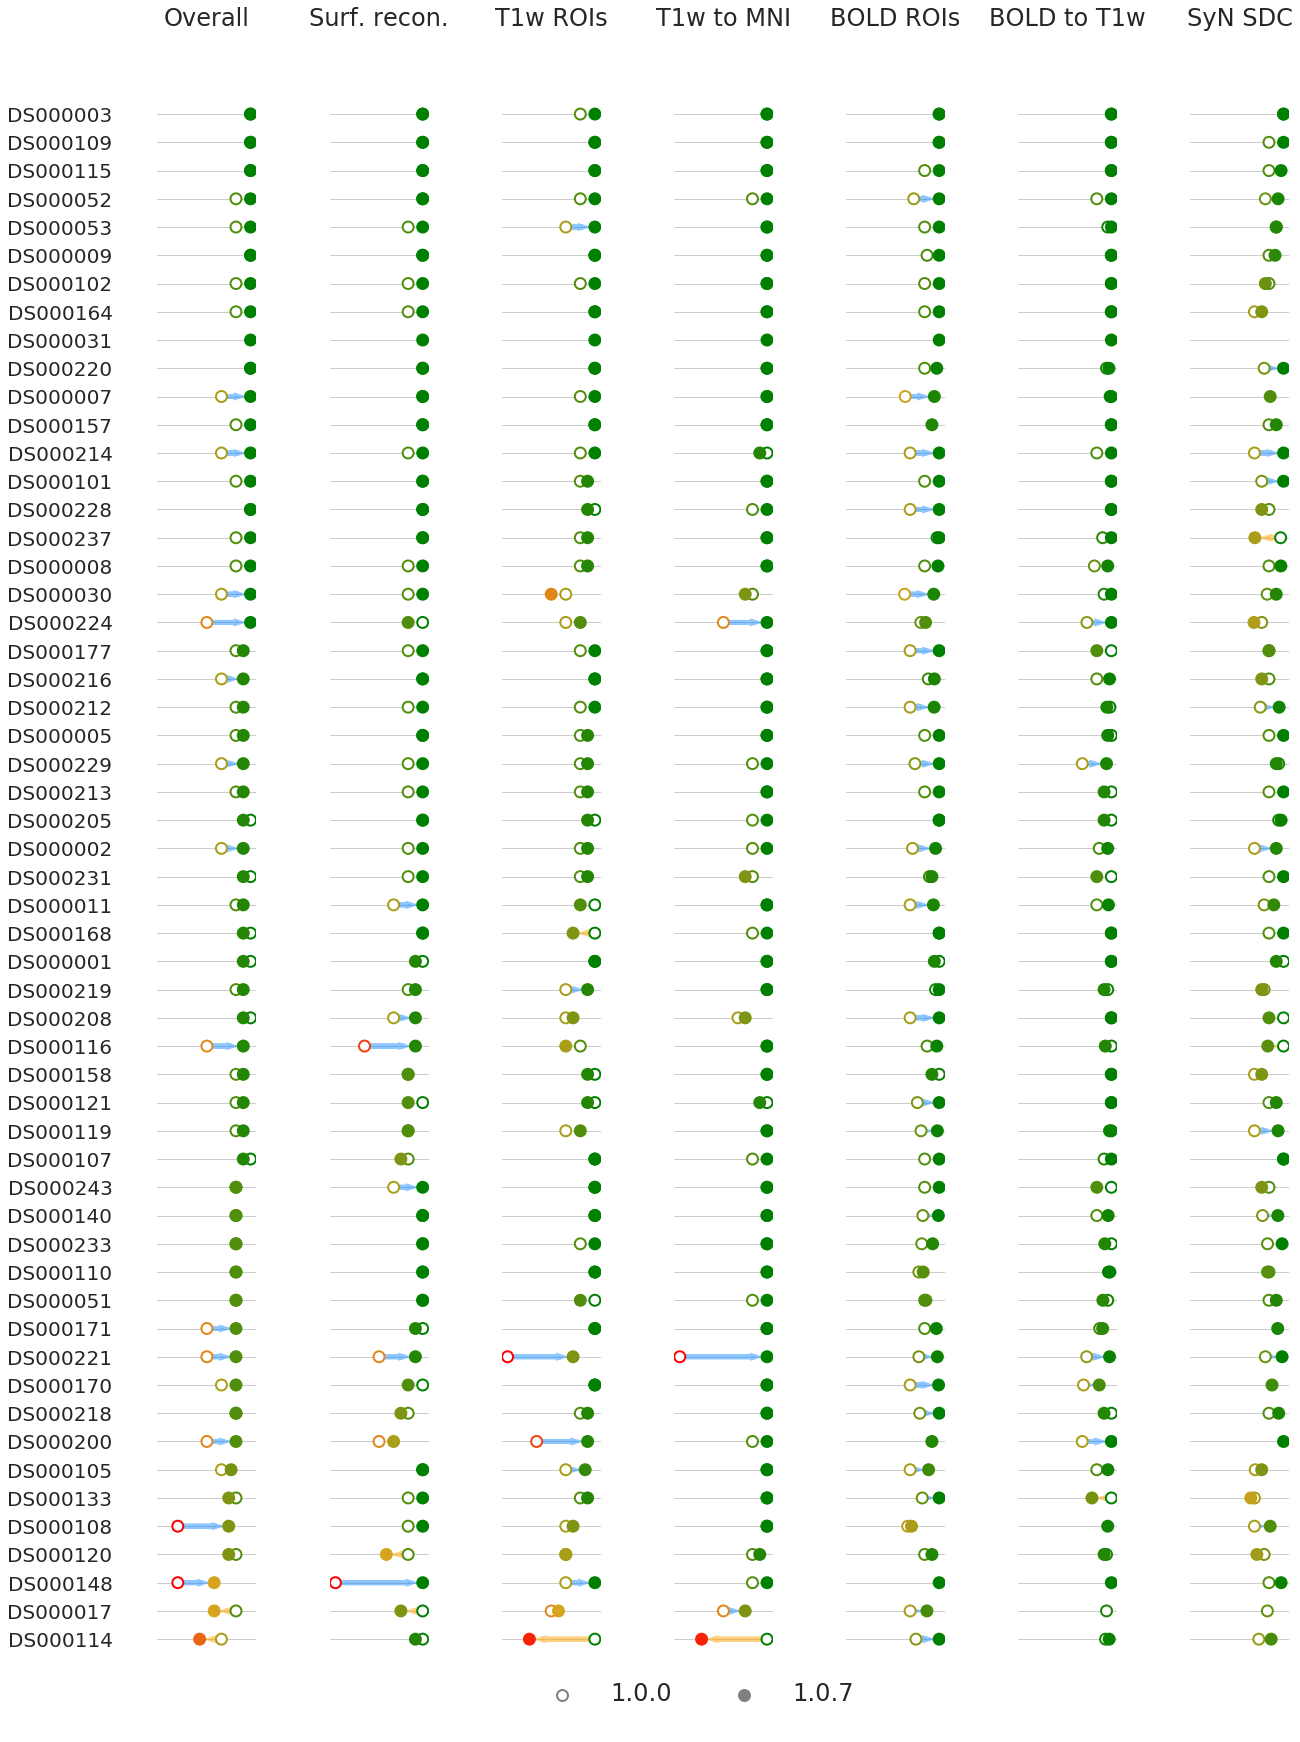

In [5]:
sns.set_context("notebook", font_scale=2)

pgf_with_custom_preamble = {
    'ytick.major.size': 0,
    'xtick.major.size': 0,
    'font.sans-serif': ['HelveticaLTStd-Light'],
    'font.family': 'sans-serif', # use serif/main font for text elements
    'text.usetex': False,    # use inline math for ticks
}
mpl.rcParams.update(pgf_with_custom_preamble)

# Make the PairGrid
g = MyPairGrid(
    df1,
    df0,
    x_vars=['overall', 't1_reconall', 't1_seg_brainmask', 't1_t1_2_mni',
            'bold_rois', 'bold_bbr', 'bold_syn_sdc'],
    y_vars=['dataset'],
    size=25, aspect=.10)

# Draw a dot plot using the stripplot function
g.map(mystripplot, size=15, orient="h")

# Use semantically meaningful titles for the columns
titles = ["Overall", "Surf. recon.", "T1w ROIs", 
          "T1w to MNI", "BOLD ROIs", "BOLD to T1w", "SyN SDC"]

# Use the same x axis limits on all columns and add better labels
g.set(xlim=(-0.2, 3.2), xlabel='', ylabel='')

datasets = df1.dataset.values.ravel()
g.axes.flat[0].set(yticks=range(len(datasets))[::-1])
g.axes.flat[0].set(yticklabels=datasets)
g.axes.flat[0].tick_params(axis='y', which='major', pad=45)
for ax, title in zip(g.axes.flat, titles):
    # Set a different title for each axes
    ax.set(title=title)
#    ax.set(xlabel=title)
    ax.set(xticks=[])
    
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)


sc = [
    plt.scatter([],[], c='w', linewidth=2, edgecolors='gray', s=120, zorder=2),
    plt.scatter([],[], c='gray', linewidth=2, edgecolors='gray', s=120, zorder=2),   
]

labels = ["1.0.0", "1.0.7"]

leg = plt.legend(sc, labels, ncol=2, frameon=False, fontsize=24,
                 handlelength=2, loc='lower center', borderpad = 1.2,
                 handletextpad=1, scatterpoints = 1,
                 bbox_to_anchor=(-5, -0.015))

# plt.savefig(str(OUTPUT_PATH / 'figureS06.pdf'),
#             format='pdf', bbox_inches='tight', pad_inches=0.5, dpi=300)